# FIT5202 - Data processing for Big data
## Semester 2, 2020
***

# Assignment 2 - Detecting Linux system hacking activities
<br>

**Background**

StopHacking is a start-up incubated in Monash University to develop cloud service to detect and stop computer hackers. Although they have some rule-based service to identify certain hacks, they would like to add machine learning models which can integrate with their Spark cluster to process large amounts of data and detect any potential hacks. They hired us as the Analytics Engineer to investigate the open data from the Cyber Range Labs of UNSW Canberra and build models based on the data to identify abnormal system behaviour. In addition, they want us to help them integrate the machine learning models into the streaming platform using Apache Kafka and Apache Spark Streaming to detect any real-time threats, in order to stop the hacking. Here, we only want to process the static data and train machine learning models based on them.<br><br>
**Required Datasets:**<br>
Two datasets: Linux - Process and Memory activity datasets

## Student Information
*** 
Name: <br>
<span style="color: brown">Abhilash Anil Kale</span><br><br>
Student number: <br>
<span style="color: brown">30254140</span><br><br>
Tutorial number:<br>
<span style="color: brown">16-P2</span><br><br>
Tutors:<br>
<span style="color: brown">Prajwol Sangat & Neha Jain</span><br><br>
Environment:<br>
<span style="color: brown">Python *3.8.2* and Spark *3.0* </span>

## Table of Contents

* [1. Data preparation and exploration](#1)
    * [1.1 Creating Spark Session](#1.1)
    * [1.2 Loading the data](#1.2)
    * [1.3 Exploring the data](#1.3)
* [2. Feature extraction and ML training](#2)
    * [2.1 Preparing the training data and testing data](#2.1)
    * [2.2 Preparing features, labels and models](#2.2)
    * [2.3 Training and evaluating models](#2.3)
* [3. Knowledge sharing](#3)
    * [3.1 Simple KMeans Model - Spark UI -- Screenshot](#3.1)
    * [3.2 Simple KMeans Model - Spark UI -- Explanation](#3.2)

### Import the required libraries

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf
# Import SparkSession classes 
from pyspark.sql import SparkSession

# Import the spark sql libraries
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame

# Import the ML libraries
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline, Transformer

# Import the evaluation libraries
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve

# Import additional libraries (kindly uncomment the pip install commands to install the respective packages if not already)
# pip install numpy
import numpy as np
# pip install pandas
import pandas as pd
# pip install seaborn
import seaborn as sns
# pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain
from typing import Iterable

# 1. Data preparation and exploration <a class="anchor" id="1"></a>
## 1.1 Creating Spark Session <a class="anchor" id="1.1"></a>

 <div class="alert alert-block alert-info">
1. Create a SparkConf object for using as many local cores as possible, for a proper
application name, and for changing the max partition byte configuration to enable a
minimum of 2 partitions when reading each file in Spark SQL (so each dataframe
should have at least 4 partitions when reading from the given datafiles).<br>
2. Then create a SparkSession using the SparkConf object.

In [2]:
# Run Spark locally with as many working processors as logical cores on the machine
master = 'local[*]'
# Setup an appropriate application name
app_name = 'Detecting Linux system hacking activities'
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Initialize Spark Session and create a SparkContext Object with a defined max partition byte configuration of 35 MB
spark = SparkSession.builder.config(conf = spark_conf).config('spark.sql.files.maxPartitionBytes', 35000000).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## 1.2 Loading the data <a class="anchor" id="1.2"></a>

 <div class="alert alert-block alert-info">
1. Load each activity data into a Spark dataframe and cache the data. Then print out
the row count of each dataframe.

In [3]:
# Define the schema for reading process csv
processSchema = StructType([
    StructField('ts', IntegerType(), True),
    StructField('PID', IntegerType(), True),
    StructField('TRUN', IntegerType(), True),
    StructField('TSLPI', IntegerType(), True),
    StructField('TSLPU', IntegerType(), True),
    StructField('POLI', StringType(), True),
    StructField('NICE', IntegerType(), True),
    StructField('PRI', IntegerType(), True),
    StructField('RTPR', IntegerType(), True),
    StructField('CPUNR', IntegerType(), True),
    StructField('Status', StringType(), True),
    StructField('EXC', IntegerType(), True),
    StructField('State', StringType(), True),
    StructField('CPU', DoubleType(), True),
    StructField('CMD', StringType(), True),
    StructField('attack', DoubleType(), True),
    StructField('type', StringType(), True)
])

# Define the schema for reading memory csv
memorySchema = StructType([
    StructField('ts', IntegerType(), True),
    StructField('PID', IntegerType(), True),
    StructField('MINFLT', StringType(), True),
    StructField('MAJFLT', StringType(), True),
    StructField('VSTEXT', StringType(), True),
    StructField('VSIZE', DoubleType(), True),
    StructField('RSIZE', StringType(), True),
    StructField('VGROW', StringType(), True),
    StructField('RGROW', StringType(), True),
    StructField('MEM', DoubleType(), True),
    StructField('CMD', StringType(), True),
    StructField('attack', DoubleType(), True),
    StructField('type', StringType(), True)
])

In [4]:
# Import all the Process csv files into single DataFrame and cache it
df_process = spark.read.format('csv')\
            .schema(processSchema).option('header', True).option('escape','"')\
            .load('data/*process*.csv').cache()

# Import all the Memory csv files into single DataFrame and cache it
df_memory = spark.read.format('csv')\
            .schema(memorySchema).option('header', True).option('escape','"')\
            .load('data/*memory*.csv').cache()

In [5]:
# Print out the number of partitions for each DF
print('NUMBER OF PARTITIONS:')
print('Process DF :', df_process.rdd.getNumPartitions())
print('Memory DF  :', df_memory.rdd.getNumPartitions())

NUMBER OF PARTITIONS:
Process DF : 4
Memory DF  : 4


In [6]:
# Print out the number of rows and columns for each DF
print('The process DF has', df_process.count(), 'rows and', len(df_process.columns), 'columns.')
print('The memory DF has', df_memory.count(), 'rows and', len(df_memory.columns), 'columns.')

The process DF has 1927968 rows and 17 columns.
The memory DF has 2000000 rows and 13 columns.


### Data Cleaning

 <div class="alert alert-block alert-info">
Clean the data in NICE column in the Process DF.

In [7]:
# Clean the data in NICE column based on the requirement of PRI column
# Only the available values of PRI in the data have been considered

# Create a new column for the refined values of NICE column
new_column = when(df_process.PRI == 100, -20)\
            .when(df_process.PRI == 109, -11)\
            .when(df_process.PRI == 110, -10)\
            .when(df_process.PRI == 121, 1)\
            .when(df_process.PRI == 130, 10)\
            .when(df_process.PRI == 139, 19)\
            .otherwise(0)

# Drop the previous unclean NICE column and append the new column as the new NICE column
df_process = df_process.drop('NICE').withColumn('NICE', new_column)

 <div class="alert alert-block alert-info">
Clean the data in multiple columns with 'String-in-Float' issue in the Memory DF.

In [8]:
# Define a function to clean the inconsistencies observed in the columns
def clean(x):
    # Remove the white spaces
    if ' ' in x:
        x = x.replace(' ','')
    # Replace the K with multiples of thousands
    if 'K' in x:
        # A different treatment if decimal is found with one less zero to add
        if '.' in x:
            x = x.replace('.', '')
            x = x.replace('K', '00')
        else:
            x = x.replace('K', '000')
    # Replace the M with multiples of millions
    if 'M' in x:
        # A different treatment if decimal is found with one less zero to add
        if '.' in x:
            x = x.replace('.', '')
            x = x.replace('M', '00000')
        else:
            x = x.replace('M', '000000')
    return x

# Create a user defined function for better usage
transform = udf(clean, StringType())

# Pass the respective columns through the function
df_memory = df_memory.withColumn('MINFLT', transform(df_memory['MINFLT']))\
                    .withColumn('MAJFLT', transform(df_memory['MAJFLT']))\
                    .withColumn('VSTEXT', transform(df_memory['VSTEXT']))\
                    .withColumn('RSIZE', transform(df_memory['RSIZE']))\
                    .withColumn('VGROW', transform(df_memory['VGROW']))\
                    .withColumn('RGROW', transform(df_memory['RGROW']))

# Convert the data types of these columns to their appropriate ones
df_memory = df_memory.withColumn('MINFLT', df_memory['MINFLT'].cast(IntegerType()))\
                    .withColumn('MAJFLT', df_memory['MAJFLT'].cast(DoubleType()))\
                    .withColumn('VSTEXT', df_memory['VSTEXT'].cast(DoubleType()))\
                    .withColumn('RSIZE', df_memory['RSIZE'].cast(DoubleType()))\
                    .withColumn('VGROW', df_memory['VGROW'].cast(DoubleType()))\
                    .withColumn('RGROW', df_memory['RGROW'].cast(DoubleType()))

### Check the data

In [9]:
# Print out the schema for Process DF
df_process.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: double (nullable = true)
 |-- type: string (nullable = true)
 |-- NICE: integer (nullable = false)



In [10]:
# Print out the schema for Memory DF
df_memory.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: double (nullable = true)
 |-- type: string (nullable = true)



In [11]:
# Sample display of the Process DF
print('PROCESS ACTIVITY DF:')
df_process.show(5)

PROCESS ACTIVITY DF:
+----------+----+----+-----+-----+----+---+----+-----+------+---+-----+---+--------------+------+------+----+
|        ts| PID|TRUN|TSLPI|TSLPU|POLI|PRI|RTPR|CPUNR|Status|EXC|State|CPU|           CMD|attack|  type|NICE|
+----------+----+----+-----+-----+----+---+----+-----+------+---+-----+---+--------------+------+------+----+
|1556739928|2579|   0|    1|    0|norm|120|   0|    0|     -|  0|    S|0.0|upstart-dbus-b|   0.0|normal|   0|
|1556739933|3739|   0|    1|    0|norm|120|   0|    0|     -|  0|    S|0.0|   kworker/0:1|   0.0|normal|   0|
|1556739938|3752|   0|    4|    0|norm|120|   0|    1|     -|  0|    S|0.0|gnome-terminal|   0.0|normal|   0|
|1556739943|2596|   0|    4|    0|norm|120|   0|    3|     -|  0|    S|0.0|unity-settings|   0.0|normal|   0|
|1556739948|1400|   0|    1|    0|norm|120|   0|    2|     -|  0|    S|0.0|    irqbalance|   0.0|normal|   0|
+----------+----+----+-----+-----+----+---+----+-----+------+---+-----+---+--------------+------+--

In [12]:
# Sample display of the Memory DF
print('MEMORY ACTIVITY DF:')
df_memory.show(5)

MEMORY ACTIVITY DF:
+----------+----+------+------+------+-----+------+-----+-----+---+--------------+------+------+
|        ts| PID|MINFLT|MAJFLT|VSTEXT|VSIZE| RSIZE|VGROW|RGROW|MEM|           CMD|attack|  type|
+----------+----+------+------+------+-----+------+-----+-----+---+--------------+------+------+
|1556743448|2123|     9|   0.0| 596.0|191.7|4712.0|  0.0|  0.0|0.0|       apache2|   0.0|normal|
|1556743453|2925|     0|   0.0| 350.0|315.3|4596.0|  0.0|  0.0|0.0|mission-contro|   0.0|normal|
|1556743458|1192|     2|   0.0|1071.0|342.1|4528.0|  0.0|  0.0|0.0|NetworkManager|   0.0|normal|
|1556743463|1404|     0|   0.0|  47.0|505.2|3584.0|  0.0|  0.0|0.0|      whoopsie|   0.0|normal|
|1556743468|3238|     0|   0.0|  18.0|368.9|3516.0|  0.0|  0.0|0.0|deja-dup-monit|   0.0|normal|
+----------+----+------+------+------+-----+------+-----+-----+---+--------------+------+------+
only showing top 5 rows



 <div class="alert alert-block alert-info">
2. Check the null data.

In [13]:
# Print out the null value count for Process DF
print('NULL VALUE COUNT FOR PROCESS ACTIVITY:')
df_process.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_process.columns]).show()

NULL VALUE COUNT FOR PROCESS ACTIVITY:
+---+---+----+-----+-----+----+---+----+-----+------+---+-----+---+---+------+----+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|NICE|
+---+---+----+-----+-----+----+---+----+-----+------+---+-----+---+---+------+----+----+
|  0|  0|   0|    0|    0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|   0|
+---+---+----+-----+-----+----+---+----+-----+------+---+-----+---+---+------+----+----+



In [14]:
# Print out the null value count for Memory DF
print('NULL VALUE COUNT FOR MEMORY ACTIVITY:')
df_memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_memory.columns]).show()

NULL VALUE COUNT FOR MEMORY ACTIVITY:
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



## 1.3 Exploring the data <a class="anchor" id="1.3"></a>

 <div class="alert alert-block alert-info">
1. Show the count of attack and non-attack in each activity based on the column
“attack”, then show the count of each kind of attack in process activity based on the
column “type”.

In [15]:
# Print out the value count for Process DF based on attack column
print('VALUE COUNT FOR PROCESS ACTIVITY BASED ON ATTACK COLUMN:')
df_process.groupBy('attack').count().show()

VALUE COUNT FOR PROCESS ACTIVITY BASED ON ATTACK COLUMN:
+------+-------+
|attack|  count|
+------+-------+
|   0.0|1636604|
|   1.0| 291364|
+------+-------+



In [16]:
# Print out the value count for Process DF based on type column
print('VALUE COUNT FOR PROCESS ACTIVITY BASED ON TYPE COLUMN:')
df_process.filter(col('attack') == 1).groupBy('type').count().show()

VALUE COUNT FOR PROCESS ACTIVITY BASED ON TYPE COLUMN:
+---------+-----+
|     type|count|
+---------+-----+
|      xss|17759|
| password|51409|
| scanning|38449|
|     ddos|71603|
|     mitm|  112|
|injection|41311|
|      dos|70721|
+---------+-----+



In [17]:
# Print out the value count for Memory DF based on attack column
print('VALUE COUNT FOR MEMORY ACTIVITY BASED ON ATTACK COLUMN:')
df_memory.groupBy('attack').count().show()

VALUE COUNT FOR MEMORY ACTIVITY BASED ON ATTACK COLUMN:
+------+-------+
|attack|  count|
+------+-------+
|   0.0|1794377|
|   1.0| 205623|
+------+-------+



In [18]:
# Print out the value count for Memory DF based on type column
print('VALUE COUNT FOR MEMORY ACTIVITY BASED ON TYPE COLUMN:')
df_memory.filter(col('attack') == 1).groupBy('type').count().show()

VALUE COUNT FOR MEMORY ACTIVITY BASED ON TYPE COLUMN:
+---------+-----+
|     type|count|
+---------+-----+
| password|26016|
|     ddos|45689|
|     mitm|  112|
|injection|58523|
|      dos|75283|
+---------+-----+



 <div class="alert alert-block alert-warning">
 <span style="color: green"><b>Answer</b></span><br>
Yes, we can observe a problem of high class imbalance for both, process and memory activities. There exists a huge difference in the number of records of the two classes, 'attack' and 'non-attack'. In the process activity, approx. only 15% of the records are labeled 'attack', whereas in the memory activity, approx. only 10% of the records are labeled 'attack'. Remaining respective 85% and 90% are all 'non-attack' records. This problem will affect the model while training, as the 'non-attack' records might dominate the training process.

 <div class="alert alert-block alert-info">
2. For each numeric feature in each activity, show the basic statistics (including count,
mean, stddev, min, max); for each non-numeric feature in each activity, display the
top-10 values and the corresponding counts.

In [19]:
# Define the numerical and non-numerical columns for Process activity respectively 
cols_num_process = ['ts', 'PID', 'TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'EXC', 'CPU']
cols_non_num_process = ['POLI', 'Status', 'State', 'CMD']

# Define the numerical and non-numerical columns for Memory activity respectively
cols_num_memory = ['ts', 'PID', 'MINFLT', 'MAJFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'VGROW', 'RGROW', 'MEM']
cols_non_num_memory = ['CMD']

# Create separate numerical and non-numberical DFs for Process activity
df_num_process = df_process[cols_num_process]
df_non_num_process = df_process[cols_non_num_process]

# Create separate numerical and non-numberical DFs for Memory activity
df_num_memory = df_memory[cols_num_memory]
df_non_num_memory = df_memory[cols_non_num_memory]

In [20]:
# Print out the basic summary statistics for Process activity's numerical columns
print('SUMMARY STATISTICS FOR PROCESS ACTIVITY:')
df_num_process.describe().toPandas()

SUMMARY STATISTICS FOR PROCESS ACTIVITY:


,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,-4.598261485667812,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527299209041
2,stddev,771350.0247982449,4987.784329320426,0.2478258709041596,6.988459728531847,0.044218744192145894,8.423057606763138,22.62444506210287,0.0,1.5274047225902962,1.4619498567691998,0.13628943687184258
3,min,1554216855,1007,0,0,0,-20,0,0,0,0,0.0
4,max,1557593017,53080,12,70,21,19,139,0,5,127,4.02


In [21]:
# Print out the top value counts for non-nummerical columns in Process activity
print('NON-NUMERICAL COLUMNS IN PROCESS ACTIVITY: \n')
for column in cols_non_num_process:
    print('Value count for', column, 'column:')
    df_non_num_process.groupBy(column).count().sort('count', ascending = False).show(10)

NON-NUMERICAL COLUMNS IN PROCESS ACTIVITY: 

Value count for POLI column:
+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

Value count for Status column:
+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

Value count for State column:
+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

Value count for CMD column:
+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



In [22]:
# Print out the basic summary statistics for Memory activity's numerical columns
print('SUMMARY STATISTICS FOR MEMORY ACTIVITY:')
df_num_memory.describe().toPandas()

SUMMARY STATISTICS FOR MEMORY ACTIVITY:


,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,987846.5873270468,46453.27415208852,4496.419966447715,23722.888664202426,984.4668735599995,483.17466255,0.0033851650000013937
2,stddev,984463.3682810809,4887.313351921479,19229.61098064222,1.4842874238099096E7,658730.2051542986,9046.338093398974,1986383.1808735176,86174.82585202328,1491.4761059171888,0.01094342577998578
3,min,1554216855,1007,0,0.0,0.0,0.0,-9728.0,-9392000.0,0.0,0.0
4,max,1558355716,53096,8050000,2.244E8,1.12E7,88040.0,2.244E8,1.116E7,98920.0,0.44


In [23]:
# Print out the top value counts for non-nummerical columns in Memory activity
print('NON-NUMERICAL COLUMNS IN MEMORY ACTIVITY: \n')
for column in cols_non_num_memory:
    print('Count for', column, 'column:')
    df_non_num_memory.groupBy(column).count().sort('count', ascending = False).show(10)

NON-NUMERICAL COLUMNS IN MEMORY ACTIVITY: 

Count for CMD column:
+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



 <div class="alert alert-block alert-info">
3. For each activity, present two plots worthy of presenting to the StopHacking
company, describe your plots and discuss the findings from the plots

In [24]:
# Sample both the DFs to 10% and convert them to pandas for plotting the graphs
df_process_sample = df_process.sample(False, 0.1, seed = 2020).toPandas()
df_memory_sample = df_memory.sample(False, 0.1, seed = 2020).toPandas()

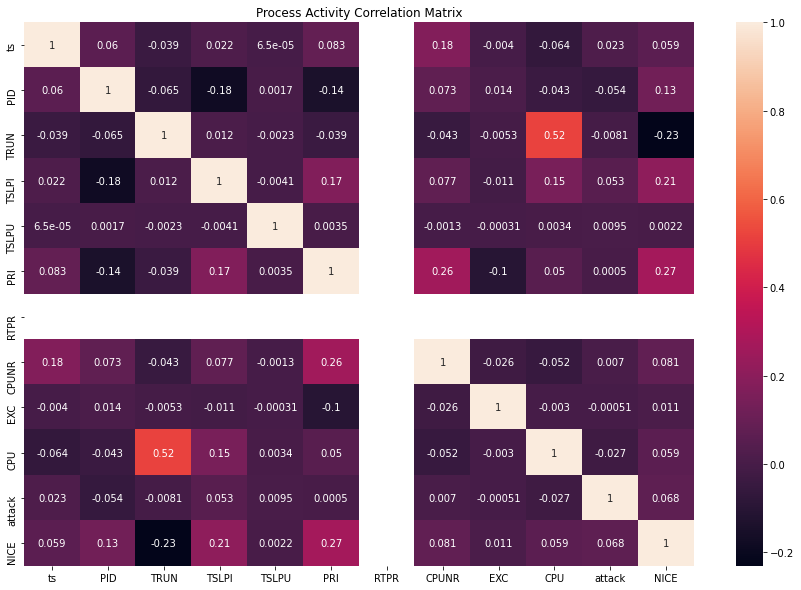

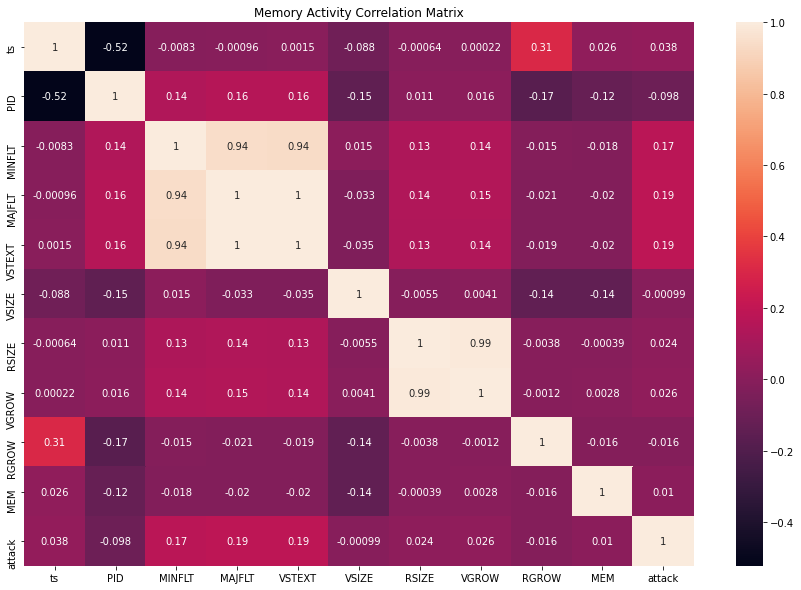

In [25]:
# Define the size of the figure
plt.figure(figsize = (15, 10))
# Define and plot the correlation matrix for the process activity's numeric columns
corrMatrix = df_process_sample.corr()
ax = sns.heatmap(corrMatrix, annot = True).set_title('Process Activity Correlation Matrix')
plt.show()

print('\n')

# Define the size of the figure
plt.figure(figsize=(15, 10))
# Define and plot the correlation matrix for the process activity's numeric columns
corrMatrix = df_memory_sample.corr()
ax = sns.heatmap(corrMatrix, annot = True).set_title('Memory Activity Correlation Matrix')
plt.show()

 <div class="alert alert-block alert-warning">
 <span style="color: green"><b>Answer</b></span><br>
The above shown plots are correlation matrices for each of the activities. These plots show the correlation of each numeric column with every other numeric column in the dataframe. The correlation coefficient observed against each pair of columns. Here, ‘attack’ column being our label column to predict, we can see that it has pretty weak relationships with majority of the other columns as the scores are near 0, for both the activities. Although, there are other columns, e.g. ‘CPU’ and ‘TRUN’ in process, and ‘MINFLT’ and ‘MAJFLT’ in memory, who show high correlation between each other.

Process Activity Timestamp Histogram with respect to Attack


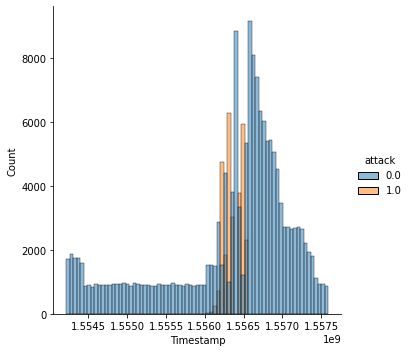


Memory Activity Timestamp Histogram with respect to Attack


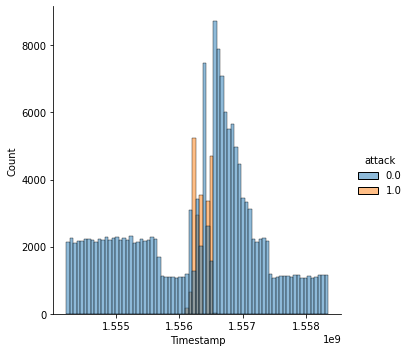

In [26]:
# Set the color codes for the plot
sns.set_color_codes()

# Plot the timestamp histogram for process activity with respect to attack
ax = sns.displot(df_process_sample, x = 'ts', hue = 'attack', bins = 75).set(xlabel='Timestamp')
print('Process Activity Timestamp Histogram with respect to Attack')
plt.show()

# Plot the timestamp histogram for memory activity with respect to attack
ax = sns.displot(df_memory_sample, x = 'ts', hue = 'attack', bins = 75).set(xlabel='Timestamp')
print('\nMemory Activity Timestamp Histogram with respect to Attack')
plt.show()

 <div class="alert alert-block alert-warning">
 <span style="color: green"><b>Answer</b></span><br>
The above shown histograms are with respect to the ‘attack’ column to show the differences between the timestamp occurrences as when the activities were attacked and not attacked. Here, we can see that for both the activities, the records with attacks are clustered together at neared timestamps. This tell us that the attacks might happen at some particular time of the day. Although, we are not treating this case as a time-series model. Hence logically, the ‘ts’ column is something to think about before including, as it may result in overfitting.

# 2. Feature extraction and ML training <a class="anchor" id="2"></a>
## 2.1 Preparing the training data and testing data <a class="anchor" id="2.1"></a>

 <div class="alert alert-block alert-info">
1. Randomly split the dataset into 80% training data and 20% testing data for each use
case

In [27]:
# Split both the DFs into train and test datasets
train_process, test_process = df_process.randomSplit([0.8, 0.2], seed = 2020)
train_memory, test_memory = df_memory.randomSplit([0.8, 0.2], seed = 2020)

 <div class="alert alert-block alert-info">
2. With the class imbalance observed from 1.3.1, for the binary classification use case 1
& 2, prepare rebalanced training data, with attack events and non-attack events
being 1:2 ratio, while using 20% attack events data from the training data from 2.1.1.
Cache the rebalanced training data, and display the count of each event's data.

In [28]:
# Sample both the train datasets to create smaller respective train datasets
train_process_sample = train_process.sample(False, 0.2, seed = 2020)
train_memory_sample = train_memory.sample(False, 0.2, seed = 2020)

In [29]:
# Define a function to undersample the data based on the required column and ratio of records
def undersample(df, ratio, column, base_class):
    # Filter out the 2 classes in the passed column
    positive = df.filter(col(column) == base_class)
    negative = df.filter(col(column) != base_class)
    
    # Store the count of both classes
    total_positive = positive.count()
    total_negative = negative.count()
    
    # Calculate and return only the required amount of columns for both classes based on the ratio
    fraction = float(total_positive * ratio) / float(total_negative)
    sampled = negative.sample(False, fraction)
    return sampled.union(positive)

In [30]:
# Pass the further split Process DF in the undersample function and store the returned dataset
rebalanced_process = undersample(train_process_sample, 2, 'attack', 1)
# Cache the rebalanced training data
rebalanced_process = rebalanced_process.cache()

# Pass the further split Memory DF in the undersample function and store the returned dataset
rebalanced_memory = undersample(train_memory_sample, 2, 'attack', 1)
# Cache the rebalanced training data
rebalanced_memory = rebalanced_memory.cache()

In [31]:
# Print out the count of records and the value count based on attack column
print('Count of records in the process rebalanced training data:', rebalanced_process.count())
rebalanced_process.groupBy('attack').count().show()

Count of records in the process rebalanced training data: 139804
+------+-----+
|attack|count|
+------+-----+
|   0.0|93268|
|   1.0|46536|
+------+-----+



In [32]:
# Print out the count of records and the value count based on attack column
print('Count of records in the memory rebalanced training data:', rebalanced_memory.count())
rebalanced_memory.groupBy('attack').count().show()

Count of records in the memory rebalanced training data: 98248
+------+-----+
|attack|count|
+------+-----+
|   0.0|65510|
|   1.0|32738|
+------+-----+



## 2.2 Preparing features, labels and models <a class="anchor" id="2.2"></a>

 <div class="alert alert-block alert-info">
1. Based on data exploration from 1.3.3, which features would you select? Discuss the
reason for selecting them and how you plan to further transform them.

 <div class="alert alert-block alert-warning">
 <span style="color: green"><b>Answer</b></span><br>
Based on the data exploration we observed above, we came across certain patterns in the data. After evaluating different set of features through training and validating them through Cross-Validation and Split-Validation, the current features have been selected along with the defined hyperparameters. Feature elimination process was also followed to achieve the best features, where the 'RTPR' column in the process activity was found with '0' values throughout, and hence was removed. The ‘attack’ column is our label column to be predicted through the model and the ‘type’ column is directly linked to that. Hence, we straight away eliminate the ‘type’ column from being considered as a feature to avoid data leakage. Additionally, columns like ‘ts’ (timestamp) and ‘PID’ together play the role of unique identifiers (composite key) for the records. Including them in the model does not make complete sense as these features are only some randomly generated numbers with very less meaning to convey. Although they show some pattern in data, but that alone does not mean that the columns are helpful in this case as we are trying to treat a classification model and not a time-series one. Including these two columns might result in overfitting and hamper the actual prediction accuracy. Also, the features with high correlation among each other result in redundancy as they contain duplicate information. Here, according to the plot, 'MAJFLT' is highly correlated with 'MINFLT' and 'VSTEXT', and 'VGROW' is highly correlated with 'RSIZE', in the memory activity. Hence, both these features, 'MAJFLT' and 'VGROW' have been omitted. No significantly high correlation is observed among the features of process activity, and hence, all the remaining features are included.<br><br>
All the other remaining columns for both activities are selected as features for the model and undergo the required feature engineering. A similar approach of transformation has been followed for both, Decision Tree and Gradient Boosted Tree model. Firstly, the non-numeric columns along with the label column, ‘attack’ so that it becomes compatible, go through the String Indexer transformer to convert the string into integers. Then the output columns of that process except for the ‘attack’ column now, go through the One Hot Encoding transformer to achieve the binary vector for each integer value passed. Further, the output columns from this process and the selected numeric columns are combined and passed through the Vector Assembler transformer to combine all of the passed features and obtain a single feature vector. Then these features would be going through the Standard Scaler transformation to achieve the final scaled down feature vector. This set of scaled features is then ready to go through the final step of the respective classifier model.
<br><br>
<i>References:<br>
    1. Dash, M., & Liu, H. (1997). Feature selection for classification. Intelligent data analysis, 1(3), 131-156<br>
    2. http://courses.washington.edu/css581/lecture_slides/05a_feature_creation_selection.pdf</i>

##### Feature Selection for each use case

In [33]:
# FOR PROCESS ACTIVITY
# Add the attack column to the non numerical columns for process
input_non_num_process = cols_non_num_process + ['attack']
input_num_process = ['TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'CPUNR', 'EXC', 'CPU']

# Define inputCols and outputCols for String Indexer for process
inputCols_process = input_non_num_process
outputCols_process = [f'{x}_index' for x in cols_non_num_process]
outputCols_process.append('label')

# Define inputCols and outputCols for OHE for process
inputCols_OHE_process = [x for x in outputCols_process if x != 'label']
outputCols_OHE_process = [f'{x}_vec' for x in cols_non_num_process]

# Define inputCols for Vector Assembler for process
inputCols_assembler_process = input_num_process + outputCols_OHE_process


# FOR MEMORY ACTIVITY
# Add the attack column to the non numerical columns for memory
input_non_num_memory = cols_non_num_memory + ['attack']
input_num_memory = ['MINFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM']

# Define inputCols and outputCols for String Indexer for memory
inputCols_memory = input_non_num_memory
outputCols_memory = [f'{x}_index' for x in cols_non_num_memory]
outputCols_memory.append('label')

# Define inputCols and outputCols for OHE for memory
inputCols_OHE_memory = [x for x in outputCols_memory if x != 'label']
outputCols_OHE_memory = [f'{x}_vec' for x in cols_non_num_memory]

# Define inputCols for Vector Assembler for memory
inputCols_assembler_memory = input_num_memory + outputCols_OHE_memory

 <div class="alert alert-block alert-info">
2. Create Transformers / Estimators for transforming / assembling the features you
selected above in 2.2.1

##### Decision Tree - Process Activity

In [34]:
# STRING INDEXER
# Define StringIndexer with the appropriate input and output columns
indexer_process = StringIndexer(inputCols = inputCols_process, outputCols = outputCols_process).setHandleInvalid('keep')

# ONE HOT ENCODER
# Define OneHotEncoder with the appropriate input and output columns
encoder_process = OneHotEncoder(inputCols = inputCols_OHE_process, outputCols = outputCols_OHE_process)

# VECTOR ASSEMBLER
# Define the VectorAssembler with appropriate input and output columns
assembler_process = VectorAssembler(inputCols = inputCols_assembler_process, outputCol = 'features')

# STANDARD SCALER
# Define the StandardScaler with the appropriate input and output column
scaler_process = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')

# ML MODEL
# Define the DecisionTreeClassifier with the appropriate label and feature column
dt_process = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'scaledFeatures',
                                   maxBins = 10, maxDepth = 30)

##### Decision Tree - Memory Activity

In [35]:
# STRING INDEXER
# Define StringIndexer with the appropriate input and output columns
indexer_memory = StringIndexer(inputCols = inputCols_memory, outputCols = outputCols_memory).setHandleInvalid('keep')

# ONE HOT ENCODER
# Define OneHotEncoder with the appropriate input and output columns
encoder_memory = OneHotEncoder(inputCols = inputCols_OHE_memory, outputCols = outputCols_OHE_memory)

# VECTOR ASSEMBLER
# Define the VectorAssembler with appropriate input and output columns
assembler_memory = VectorAssembler(inputCols = inputCols_assembler_memory, outputCol = 'features')

# STANDARD SCALER
# Define the StandardScaler with the appropriate input and output column
scaler_memory = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')

# ML MODEL
# Define the DecisionTreeClassifier with the appropriate label and feature column
dt_memory = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'scaledFeatures',
                                   maxBins = 100, maxDepth = 30)

##### Gradient Boosted Tree - Process Activity

In [36]:
# ML MODEL --> Here, no need for feature engineering as we can pass the previously created stages (in DT)
# Define the DecisionTreeClassifier with the appropriate label and feature column
gbt_process = GBTClassifier(labelCol = 'label', featuresCol = 'scaledFeatures',
                                   maxBins = 10, maxDepth = 30, maxIter = 30)

##### Gradient Boosted Tree - Memory Activity

In [37]:
# ML MODEL --> Here, no need for feature engineering as we can pass the previously created stages (in DT)
# Define the DecisionTreeClassifier with the appropriate label and feature column
gbt_memory = GBTClassifier(labelCol = 'label', featuresCol = 'scaledFeatures',
                                   maxBins = 100, maxDepth = 30)

#### Note:<br><br>The 'maxBins', 'maxDepth' and 'maxIter' hyperparameters for each model have been defined based on the Cross-Validation and Train-Validation performed on the Decision Tree and Gradient Boosted Tree models respectively.

 <div class="alert alert-block alert-info">
3. Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use
case and include them into ML Pipelines for use case 1, 2.

In [38]:
# PIPELINE API
# Pass the respective stages of the respective models in the pipeline api
pipeline_dt_process = Pipeline(stages = [indexer_process,
                                         encoder_process,
                                         assembler_process,
                                         scaler_process,
                                         dt_process])

pipeline_dt_memory = Pipeline(stages = [indexer_memory,
                                        encoder_memory,
                                        assembler_memory,
                                        scaler_memory,
                                        dt_memory])

pipeline_gbt_process = Pipeline(stages = [indexer_process,
                                          encoder_process,
                                          assembler_process,
                                          scaler_process,
                                          gbt_process])

pipeline_gbt_memory = Pipeline(stages = [indexer_memory,
                                          encoder_memory,
                                          assembler_memory,
                                          scaler_memory,
                                          gbt_memory])

## 2.3 Training and evaluating models <a class="anchor" id="2.3"></a>

 <div class="alert alert-block alert-info">
1. For each use case, use the corresponding ML Pipeline from previous step to train the
models on the rebalanced training data from 2.1.2

In [39]:
# Train the respective models on the respective rebalanced training datasets
dtModel_process = pipeline_dt_process.fit(rebalanced_process)

dtModel_memory = pipeline_dt_memory.fit(rebalanced_memory)

gbtModel_process = pipeline_gbt_process.fit(rebalanced_process)

gbtModel_memory = pipeline_gbt_memory.fit(rebalanced_memory)

 <div class="alert alert-block alert-info">
2. For each use case, test the models on the testing data from 2.1.1 and display the
count of each combination of attack label and prediction label in formats as given.

In [40]:
# Test the respective models to get predictions from the respective test data
dtPredictions_process = dtModel_process.transform(test_process)

dtPredictions_memory = dtModel_memory.transform(test_memory)

gbtPredictions_process = gbtModel_process.transform(test_process)

gbtPredictions_memory = gbtModel_memory.transform(test_memory)

In [41]:
# Create lists consisting of all predictions DFs and their respective names
predictions_df_list = [dtPredictions_process, dtPredictions_memory, gbtPredictions_process, gbtPredictions_memory]
predictions_name_list = ['DT Predictions-process', 'DT Predictions-memory', 'GBT Predictions-process', 'GBT Predictions-memory']

# Display all the prediction counts using a loop on the above created lists
for df, name in zip(predictions_df_list, predictions_name_list):
    print('Value count of', name, 'based on the label and prediction:')
    df.groupBy('attack', 'prediction').count().show()

Value count of DT Predictions-process based on the label and prediction:
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       1.0| 25706|
|   0.0|       1.0| 42435|
|   1.0|       0.0| 32674|
|   0.0|       0.0|284662|
+------+----------+------+

Value count of DT Predictions-memory based on the label and prediction:
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       1.0| 24962|
|   0.0|       1.0| 31875|
|   1.0|       0.0| 16296|
|   0.0|       0.0|326868|
+------+----------+------+

Value count of GBT Predictions-process based on the label and prediction:
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|   1.0|       1.0| 26051|
|   0.0|       1.0| 43310|
|   1.0|       0.0| 32329|
|   0.0|       0.0|283787|
+------+----------+------+

Value count of GBT Predictions-memory based on the label and prediction:
+------+----------+------+
|attack|prediction| count|
+--

 <div class="alert alert-block alert-info">
3. Compute the AUC, accuracy, recall and precision for the attack label from each
model testing result using pyspark MLlib / ML APIs. Discuss which metric is more
proper for measuring the model performance on identifying attacks.

In [42]:
# Define a function to compute all evaluation scores as a summary
def summary(predictions, model, name):
    print('Score summary for', name + ':')
    
    # Compute and print out the AUC score
    evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction')
    auc_dt = evaluator.evaluate(predictions)
    
    # Compute and print out the Accuracy score
    evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName = 'accuracy')
    accuracy = evaluator.evaluate(predictions)
    
    # Compute and print out the Recall and Precision scores
    predictions_labels = predictions.select('prediction', 'label')
    metrics = MulticlassMetrics(predictions_labels.rdd)
    recall = metrics.recall(label = 1)
    precision = metrics.precision(label = 1)
    
    # Create a DF of all the metrics
    df = spark.createDataFrame(
        [
            ('AUC', auc_dt),
            ('Accuracy', accuracy),
            ('Recall', recall),
            ('Precision', precision)
        ],
        ['Metric', 'Score']
    )
    df = df.withColumn('Score', round(df['Score'], 4))
    # Print out the metrics DF
    df.show()


# Pass the respective predictions, models and their respective names in the above created function
summary(dtPredictions_process, dtModel_process, 'DT Predictions-process')
summary(dtPredictions_memory, dtModel_memory, 'DT Predictions-memory')
summary(gbtPredictions_process, gbtModel_process, 'GBT Predictions-process')
summary(gbtPredictions_memory, gbtModel_memory, 'GBT Predictions-memory')

Score summary for DT Predictions-process:
+---------+------+
|   Metric| Score|
+---------+------+
|      AUC|0.5545|
| Accuracy|0.8052|
|   Recall|0.4403|
|Precision|0.3772|
+---------+------+

Score summary for DT Predictions-memory:
+---------+------+
|   Metric| Score|
+---------+------+
|      AUC|0.7136|
| Accuracy|0.8796|
|   Recall| 0.605|
|Precision|0.4392|
+---------+------+

Score summary for GBT Predictions-process:
+---------+------+
|   Metric| Score|
+---------+------+
|      AUC|0.7726|
| Accuracy|0.8038|
|   Recall|0.4462|
|Precision|0.3756|
+---------+------+

Score summary for GBT Predictions-memory:
+---------+------+
|   Metric| Score|
+---------+------+
|      AUC|0.8974|
| Accuracy|0.8669|
|   Recall|0.6785|
|Precision|0.4119|
+---------+------+



 <div class="alert alert-block alert-warning">
 <span style="color: green"><b>Answer</b></span><br>
<li>The AUC (Area under ROC curve) score and the Accuracy score for each model are the primary scores as appropriate measures to validate the model's performance. These scores summarise and tell us an exact overview about the how the model has been trained and whether the predictions being made while testing are near to what are expected or not. High AUC and Accuracy scores are expected as a result of good validation.</li>
<li>Here, in the case of predicting hacking attacks, we should avoid the risk of missing any probable attacks. Hence, the Recall score should also be considered as a measure. A high Recall score is expected as a result of good validation.</li>
<br>PS - We need to keep in mind that the scores are not too high as the models might face the problem of overfitting.

 <div class="alert alert-block alert-info">
4. Display the top-5 most important features in each model. Discuss which pipeline
model is better, and whether the feature “ts” should be included in the model. And
visualise the ROC curve for the better model you selected for each use case.

In [43]:
# Define a function to extract the top 5 most important features from each model
def imp_features(predictions, model, name):
    print('Top 5 most important features for', name + ':')
    
    # Iterate through the predictions using chain to extract the features and attrs
    attrs = sorted((attr['idx'], attr['name'])
                   for attr in (chain(*predictions.schema['features']
                                      .metadata['ml_attr']['attrs']
                                      .values())))

    # Extract and store the important features in a list
    features = [(name, model.stages[-1].featureImportances[idx])
                for idx, name in attrs
                if model.stages[-1].featureImportances[idx]]
    
    # Convert the list to a dataframe to display
    df = pd.DataFrame.from_records(features, columns = ['feature', 'importance'])
    df['rank'] = df['importance'].rank(method = 'min', ascending = False)
    df = df.sort_values('rank')
    df['importance'] = df['importance'].round(5)
    df = spark.createDataFrame(df)
    df.show(5, truncate = False)
    
# Pass the predictions and models through the above created function
imp_features(dtPredictions_process, dtModel_process, 'DT Predictions-process')
imp_features(dtPredictions_memory, dtModel_memory, 'DT Predictions-memory')
imp_features(gbtPredictions_process, gbtModel_process, 'GBT Predictions-process')
imp_features(gbtPredictions_memory, gbtModel_memory, 'GBT Predictions-memory')

Top 5 most important features for DT Predictions-process:
+---------------+----------+----+
|feature        |importance|rank|
+---------------+----------+----+
|Status_vec_-   |0.26121   |1.0 |
|CPUNR          |0.09869   |2.0 |
|TSLPI          |0.09373   |3.0 |
|CPU            |0.07402   |4.0 |
|CMD_vec_apache2|0.05849   |5.0 |
+---------------+----------+----+
only showing top 5 rows

Top 5 most important features for DT Predictions-memory:
+-------+----------+----+
|feature|importance|rank|
+-------+----------+----+
|RSIZE  |0.31215   |1.0 |
|MINFLT |0.25368   |2.0 |
|VSIZE  |0.16343   |3.0 |
|VSTEXT |0.04836   |4.0 |
|RGROW  |0.048     |5.0 |
+-------+----------+----+
only showing top 5 rows

Top 5 most important features for GBT Predictions-process:
+---------------+----------+----+
|feature        |importance|rank|
+---------------+----------+----+
|Status_vec_-   |0.17195   |1.0 |
|CPUNR          |0.13842   |2.0 |
|TSLPI          |0.09795   |3.0 |
|CPU            |0.08722   |4.0 

 <div class="alert alert-block alert-warning">
 <span style="color: green"><b>Answer</b></span><br>
Based on the comparison of the metric scores, i.e. AUC, Accuracy and Recall scores, among the four different results, it is observed that the pipeline for Gradient Boosted Tree model for both the activities, process and memory, performs better and gives out better results. As the name suggests, Gradient Boosted Tree uses the gradient boosting technique to form an ensemble of multiple decision trees. As a result, it tends to fit and perform better than the standard stand-alone Decision Tree. As observed, in this case, we are getting good AUC and Accuracy scores for both the GBT models and a satisfactory Recall score to satisfy the tested data, in comparison with the DT models. <b>Hence, I select the GBT models for both activities as the better ones to proceed further.</b><br><br>
The ‘ts’ (timestamp) feature has been omitted from both the activities’ training models, DT and GBT. The timestamp column is one of the very important features when it comes to the Computer Science, File Systems and Machine Learning domains. There have been various studies on the way timestamps should be recorded and stored for activities. And hence, discrepancies in the timestamp values in data might help us in detection of attacks on the basis of its pattern, when considered as a time-series model. In this case, the timestamp feature is probably the best feature to reveal the patterns in time-series and make certain predictions. Although, here, in the case of detecting Linux system hacking activities, we are focusing on the specific reasons from various other features, as how their different values are contributing to the attacks. As the data was further explored various causes in features were observed, for example, the average ‘RSIZE’ is way higher for attack records than that of the non-attack records. Similarly, the average ‘MAJFLT’ is also very high for the attack records when compared to the non-attack ones. There are many more observations of such kind and their depictions tell us that this case of classification is not dependent on a time-series model. And hence, combining an important feature like timestamp along with the other important features in this case is only going to make the model overfit. Instead, we focus on the other features and try to include maximum possible out of them to get the best possible prediction result.
<br><br>
    <i>References:<br>
        1. Gaikwad, P.S. & Pingat S.P. (2015). Detection of attacks based on timestamp discrepancy, Vol 4 Issue 6 <br>
        2. File Timestamps - Bradley, J. (2016). OS X incident response: scripting and analysis. Syngress.</i>

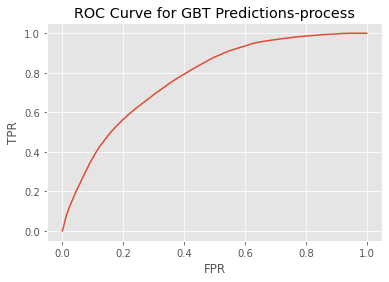

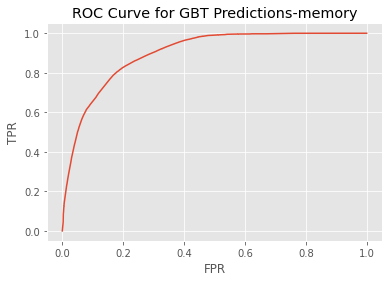

In [44]:
# Define a function to get the FPR and TPR values considering all the thresholds
def roc(predictions, name):
    # Get the probabilities as an RDD to further get the true labels and target score
    probability = predictions.select('label', 'probability')\
                            .rdd.map(lambda x: (float(x['probability'][1]), float(x['label'])))\
                            .collect()
    score, true = zip(*probability)
    
    # Get the FPR and TPR scores along with the thresholds
    fpr, tpr, thresholds = roc_curve(true, score, pos_label = 1)
    # Pass the FPR and TPR scores through the curve plotting function
    roc_curve_plot(tpr, fpr, name)

# Define a function to plot the ROC curve
def roc_curve_plot(tpr, fpr, name):
    plt.style.use('ggplot')
    plt.plot(fpr, tpr)
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('ROC Curve for ' + name)
    plt.show()

# Pass the predictions and their names through the roc function created above
roc(gbtPredictions_process, 'GBT Predictions-process')
roc(gbtPredictions_memory, 'GBT Predictions-memory')

 <div class="alert alert-block alert-info">
5. Using the pipeline model you selected in the previous step, re-train the pipeline
model using a bigger set of rebalanced training data, with attack events and
non-attack events being 1:2 ratio, while using all attack events data from the full data
for both use cases. Then persist the better models for each use case.

In [45]:
# Pass the main train Process dataset in the undersample function and store the returned dataset
rebalanced_process_big = undersample(train_process, 2, 'attack', 1)
# Cache the bigger rebalanced training data
rebalanced_process_big = rebalanced_process_big.cache()

# Pass the main train Memory dataset in the undersample function and store the returned dataset
rebalanced_memory_big = undersample(train_memory, 2, 'attack', 1)
# Cache the bigger rebalanced training data
rebalanced_memory_big = rebalanced_memory_big.cache()

In [46]:
# Print out the count of records and the value count based on attack column
print('Count of records in the bigger process rebalanced training data:', rebalanced_process_big.count())
rebalanced_process_big.groupBy('attack').count().show()

Count of records in the bigger process rebalanced training data: 699067
+------+------+
|attack| count|
+------+------+
|   0.0|466083|
|   1.0|232984|
+------+------+



In [47]:
# Print out the count of records and the value count based on attack column
print('Count of records in the bigger memory rebalanced training data:', rebalanced_memory_big.count())
rebalanced_memory_big.groupBy('attack').count().show()

Count of records in the bigger memory rebalanced training data: 493793
+------+------+
|attack| count|
+------+------+
|   0.0|329428|
|   1.0|164365|
+------+------+



In [48]:
# Train the best 2 models for each use case on the respective bigger rebalanced training datasets
gbtModel_process = pipeline_gbt_process.fit(rebalanced_process_big)

gbtModel_memory = pipeline_gbt_memory.fit(rebalanced_memory_big)

In [49]:
# Persist the best 2 models trained above
gbtModel_process.write().overwrite().save('process_gbt_model')

gbtModel_memory.write().overwrite().save('memory_gbt_model')

# 3. Knowledge sharing <a class="anchor" id="3"></a>
## 3.1 Simple KMeans Model - Spark UI -- Screenshot <a class="anchor" id="3.1"></a>

 <div class="alert alert-block alert-info">
1. How many jobs are observed when training the KMeans clustering model following the
code below? Provide a screenshot from Spark UI for running a simple KMeans model
training.

In [50]:
# Run the following code

iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

assembler = VectorAssembler(
    inputCols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
    outputCol = 'features')
kmeans = KMeans(k = 3).fit(assembler.transform(iris_df))

### Screenshot:

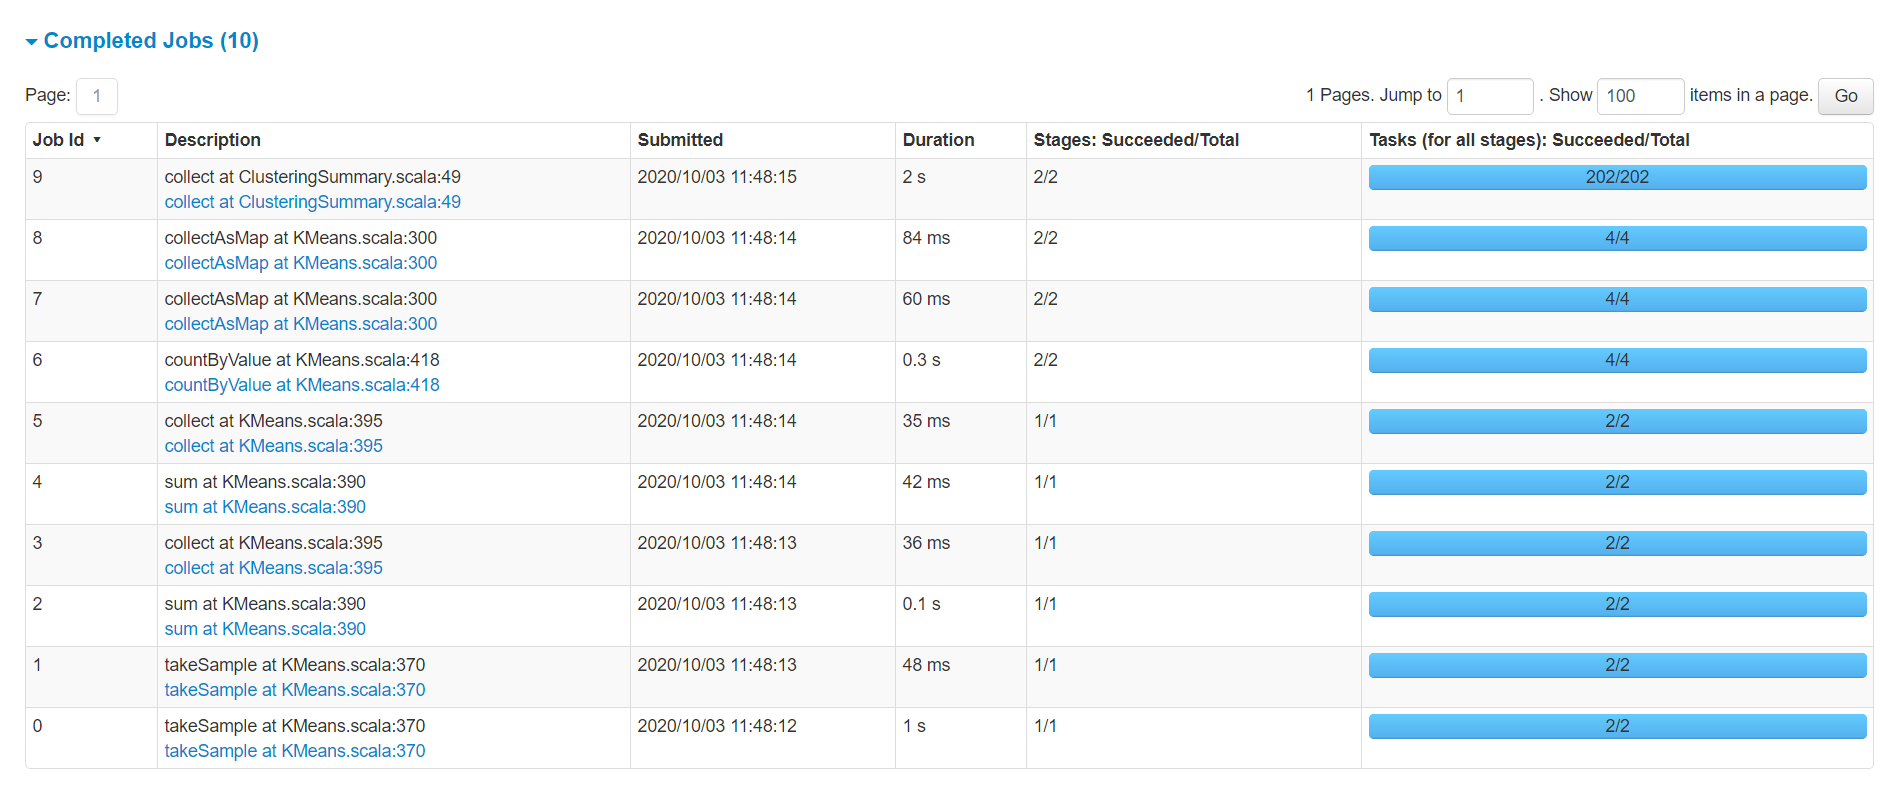

## 3.2 Simple KMeans Model - Spark UI -- Explanation <a class="anchor" id="3.2"></a>

 <div class="alert alert-block alert-warning">
 <span style="color: green"><b>Answer</b></span><br>
As we can observe in the screenshot, every time Spark SQL function is called to perform certain PySpark operations on the dataframe by the KMeans algorithm, a new job is created. Here, a total of 10 jobs are created. The created dataframe is divided into 2 default partitions when read by PySpark to achieve the necessary parallelism. The KMeans model achieves parallelism using the data parallelism technique by default in PySpark.<br><br>
After the data is transformed using the Vector Assembler, it is ready to be initialised by KMeans by choosing 3 random data points as centroids forming the 3 initial clusters. These sum up the first 2 takeSample jobs shown above. Later, the sum job calls the RDD sum function to calculate the Euclidean distance between the data points (vectors as they are vector assembled) and the centroids. This Euclidean distance with respect to the 3 centroids and the minimum distances among them are stored along with their respective data vectors and zip mapped together to be written to the disk memory, in the collect job. Both partitions undergo the same steps and hence are seen twice in the screenshot. Then a new set of centroids for the 3 clusters are derived in the countByValue job. Next, in the 2 collectAsMap jobs, the derived centroids are assigned and mapped to the respective clustered RDD using the weighted average method. The model will not run these jobs again and will finish its iterations if no new centroids are found.<br><br>
Lastly, in the collect job (of ClusteringSummary.scala class), the final prediction column is collected to define the final data points of the 3 clusters along with their final centroids using redistribution of values from all the different partitions in different processors. The algorithm ends here as we have our final 3 clusters.
<br><br>
    <i>References:<br>
1. Taniar, D., Leung, C. H., Rahayu, W., & Goel, S. (2008). High-performance parallel database processing and grid databases (Vol. 67). John Wiley & Sons.<br>
2. Hai, M., Zhang, Y., & Li, H. (2018). A performance comparison of big data processing platform based on parallel clustering algorithms. Procedia computer science, 139, 127-135.</i>